In [22]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

## Ground truth - annotation files

In [36]:
import xml.etree.ElementTree as ET

In [37]:
img_dir = "dataset/second_approach/images/"
annot_dir = "dataset/second_approach/annotations/"

In [38]:
annot = [file for file in glob.glob(annot_dir + "*.xml")]

### Let's see exemplary files content

In [7]:
annot1 = [annot[3]]+[annot[1]]
annot1

['dataset/second_approach/annotations/maksssksksss110.xml',
 'dataset/second_approach/annotations/maksssksksss380.xml']

In [39]:
def extract_faces(annotations, return_bdbox=False):
    images = []
    labels = []
    files = []
    for img_annot in annotations:
        tree = ET.parse(img_annot)
        root = tree.getroot()
        file = root.find('filename').text
        file_path = img_dir + file
        img = cv.imread(file_path)
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        x = img.shape[1]/width
        y = img.shape[0]/height
        objects = root.findall('object')
        for object in objects:
            label = object.find('name').text
            place = str(len(objects)) + ": " + label
            labels.append(place)
            bndbox = object.find('bndbox')
            xmin = int((int(bndbox.find('xmin').text))/x)
            ymin = int((int(bndbox.find('ymin').text))/y)
            xmax = int((int(bndbox.find('xmax').text))/x)
            ymax = int((int(bndbox.find('ymax').text))/y)
            if return_bdbox:
                images.append([xmin, ymin, xmax, ymax])
                files.append(file_path)
            else:
                face = img[ymin:ymax, xmin:xmax]
                images.append(face)
    if return_bdbox:
        return images, labels, files
    return images, labels

In [7]:
images1, labels1 = extract_faces(annot1)
len(labels1)

27

In [ ]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(images1)):
    img = cv.cvtColor(images1[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 9, i+1))
    plt.axis('off')
    plt.title(labels1[i])
    plt.imshow(img)   
plt.show()

What's good:
- multiple faces at one photo
- ocluded elements
- diffetent positions

## Let's take a closer look at the dataset

In [6]:
faces_on_photo = []
photo_size = []

face_sizes_area = []
face_sizes_perc = []

tiny_faces_annot = []
tiny_faces_img = []
tiny_faces = {}

for img_annot in annot:
    tree = ET.parse(img_annot)
    root = tree.getroot()
    objects = root.findall('object')
    faces_number = len(objects)
    file = root.find('filename').text
    file_path = img_dir + file
    img = cv.imread(file_path)
    img_size = img.shape[0]*img.shape[1]
    photo_size.append(img_size**0.5)
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    x = img.shape[1]/width
    y = img.shape[0]/height
    for object in objects:
        bndbox = object.find('bndbox')
        xmin = int((int(bndbox.find('xmin').text))/x)
        ymin = int((int(bndbox.find('ymin').text))/y)
        xmax = int((int(bndbox.find('xmax').text))/x)
        ymax = int((int(bndbox.find('ymax').text))/y)
        area = (xmax-xmin)*(ymax-ymin)
        if(area < 16):
            print("Tiny face: ", file, "size: ", area)
            tiny_faces_annot.append(img_annot)
            tiny_faces_img.append(file_path)
            faces_number -= 1
            if (file_path in tiny_faces):
                tiny_faces[file_path] += 1
            else:
                tiny_faces[file_path] = 1
        else:
            face_sizes_area.append(area**(0.5))
            face_sizes_perc.append(100*area/img_size)
    faces_on_photo.append(faces_number)

Tiny face:  maksssksksss64.png size:  6
Tiny face:  maksssksksss64.png size:  9
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss64.png size:  4
Tiny face:  maksssksksss64.png size:  6
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss64.png size:  2
Tiny face:  maksssksksss486.png size:  12
Tiny face:  maksssksksss603.png size:  15


### Tiny faces?

In [8]:
tiny_faces_annot = list(set(tiny_faces_annot))
tiny_faces_img = list(set(tiny_faces_img))
tiny_faces_annot

['dataset/second_approach/annotations/maksssksksss64.xml',
 'dataset/second_approach/annotations/maksssksksss603.xml',
 'dataset/second_approach/annotations/maksssksksss486.xml']

In [9]:
tiny_faces_img

['dataset/second_approach/images/maksssksksss64.png',
 'dataset/second_approach/images/maksssksksss486.png',
 'dataset/second_approach/images/maksssksksss603.png']

In [10]:
tiny_faces_img = [tiny_faces_img[i] for i in [0, 2, 1]]
tiny_faces_img

['dataset/second_approach/images/maksssksksss64.png',
 'dataset/second_approach/images/maksssksksss603.png',
 'dataset/second_approach/images/maksssksksss486.png']

In [12]:
imgs2 = []
for i in tiny_faces_img:
    imgs2.append(cv.imread(i))
images2, labels2, files2 = extract_faces(tiny_faces_annot, return_bdbox=True)
len(labels2)

134

In [48]:
from collections import Counter

In [ ]:
Counter(files2)

In [ ]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1,3, i+1))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
fig=plt.figure(figsize=(10, 15))
axes = []

for i in range(len(images2)):
    bdbox = images2[i]
    if ((bdbox[2]-bdbox[0])*(bdbox[3]-bdbox[1]) < 16):
        idx = tiny_faces_img.index(files2[i])
        cv.rectangle(imgs2[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 2)
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img) 


### Histograms

In [56]:
photo_size = [x / 10**3 for x in photo_size]
photo_characteristics = pd.DataFrame({'Faces on photo': faces_on_photo, 'Photo size (kilopixels)': photo_size})

In [ ]:
sns.displot(photo_characteristics, x='Photo size (kilopixels)', bins=int((len(photo_characteristics))**(0.5)))

In [ ]:
sns.displot(photo_characteristics, x='Faces on photo', bins=int((len(photo_characteristics))**(0.5)))

In [9]:
faces_characteristics = pd.DataFrame({'Faces area': face_sizes_area, 'Faces percentage': face_sizes_perc})

In [ ]:
sns.displot(faces_characteristics, x='Faces area', bins=int((len(faces_characteristics))**(0.5)))

In [85]:
import matplotlib.ticker as tkr

In [ ]:
fig = sns.displot(faces_characteristics, x='Faces percentage', bins=int((len(faces_characteristics))**(0.5)))
for ax in fig.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x: .0f}%'))
fig

### Exemplary files - detection check

In [24]:
img_dir = 'dataset/second_approach/images/'
exemplary_annot = ['dataset/second_approach/annotations/maksssksksss521.xml',
                  'dataset/second_approach/annotations/maksssksksss473.xml',
                  'dataset/second_approach/annotations/maksssksksss110.xml']

In [25]:
exemplary_imgs_files = ['dataset/second_approach/images/maksssksksss521.png',
                        'dataset/second_approach/images/maksssksksss473.png',
                        'dataset/second_approach/images/maksssksksss110.png']
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]

In [67]:
exemplary_images, exemplary_labels, exemplary_files = extract_faces(exemplary_annot, return_bdbox=True)

In [ ]:
fig=plt.figure(figsize=(30, 20))
axes = []

for i in range(len(exemplary_images)):
    bdbox = exemplary_images[i]
    idx = exemplary_imgs_files.index(exemplary_files[i])
    cv.rectangle(exemplary_imgs[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 1)
for i in range(len(exemplary_imgs)):
    img = cv.cvtColor(exemplary_imgs[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector 1 - OpenCV's Haar Cascades

In [94]:
haar_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

In [8]:
def haar_annotate(img_path, model):
    image = cv.imread(img_path)
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = haar_detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
    for (a, b, c, d) in faces:
        cv.rectangle(image, (a, b), (a+c, b+d), (0, 0, 255), 1)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [ ]:
fig=plt.figure(figsize=(30, 15))
axes = []
for i in range(len(exemplary_imgs_files)):
    image = haar_annotate(exemplary_imgs_files[i], haar_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(image)

In [9]:
def normalize_haar_results(filename, detector):
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    faces = detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
    faces = [[face[i] if i < 2 else face[i]+face[i-2] for i in range(len(face))] for face in faces]
    return faces

## Detector 2 - OpenCV's DNN module

In [125]:
dnn_detector = cv.dnn.readNetFromCaffe("models/deploy.prototxt.txt",
                                       "models/res10_300x300_ssd_iter_140000.caffemodel")

In [37]:
def dnn_annotate(img_path, model):
    img = cv.imread(img_path)
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    model.setInput(blob)
    detected = model.forward()
    for j in range(detected.shape[2]):
        confidence = detected[0, 0, j, 2]
        if confidence > 0.5:
            box = detected[0, 0, j, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            cv.rectangle(img, (coords[0], coords[1]), (coords[2], coords[3]), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [ ]:
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = dnn_annotate(exemplary_imgs_files[i], dnn_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [38]:
def normalize_dnn_results(filename, model):
    img = cv.imread(filename)
    faces = []
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    model.setInput(blob)
    detected = model.forward()
    for j in range(detected.shape[2]):
        confidence = detected[0, 0, j, 2]
        if confidence > 0.5:
            box = detected[0, 0, j, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            faces.append(coords)
    return faces

## Detector 3 - MTCNN

In [132]:
from mtcnn.mtcnn import MTCNN
mtcnn_detector = MTCNN()

In [292]:
def mtcnn_annotate(img_path, model):
    img = cv.imread(img_path)
    faces = model.detect_faces(img)
    for face in faces:
        bdbox =face.get('box')
        cv.rectangle(img, (bdbox[0], bdbox[1]), (bdbox[0]+bdbox[2], bdbox[1]+bdbox[3]), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [ ]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = mtcnn_annotate(exemplary_imgs_files[i], mtcnn_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [133]:
def normalize_mtcnn_results(filename, model):
    img = cv.imread(filename)
    faces = []
    boxes = model.detect_faces(img)
    for box in boxes:
        bdbox = box.get('box')
        normalized_box = [bdbox[0], bdbox[1], bdbox[0]+bdbox[2], bdbox[1]+bdbox[3]]
        faces.append(normalized_box)
    return faces

## Detector 4 - Dlib HOG

In [15]:
import dlib
hog_detector = dlib.get_frontal_face_detector()

In [218]:
def hog_annotate(img_path, model, scale=2):
    image = cv.imread(img_path)
    faces = model(image, scale)
    for face in faces:
        cv.rectangle(image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [ ]:
fig=plt.figure(figsize=(30, 15))
axes = []

changing_param = [1, 2, 4]
for j in range(len(changing_param)):
    for i in range(len(exemplary_imgs_files)):
        image = hog_annotate(exemplary_imgs_files[i], hog_detector, scale=changing_param[j])
        axes.append(fig.add_subplot(3, 3, 3*i+j+1))
        plt.axis('off')
        plt.imshow(image)

In [16]:
def normalize_hog_results(filename, model):
    img = cv.imread(filename)
    faces = []
    boxes = model(img, 2)
    for box in boxes:
        faces.append([box.left(), box.top(), box.right(), box.bottom()])
    return faces

## Detector 5 - dlib MMOD

In [40]:
import dlib
mmod_detector = dlib.cnn_face_detection_model_v1("models/mmod_human_face_detector.dat")

In [41]:
def mmod_annotate(img_path, model):
    image = cv.imread(img_path)
    faces = model(image)
    for box in faces:
        face = box.rect
        cv.rectangle(image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 0, 255), 1)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    del faces
    return image

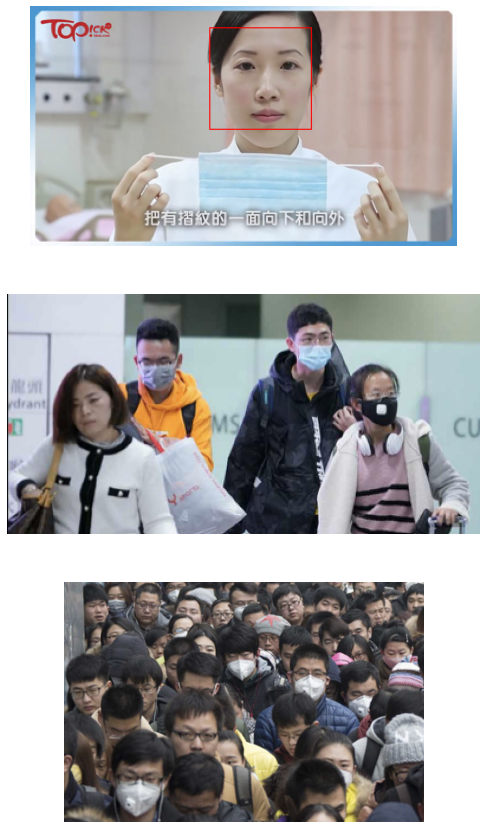

In [12]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = mmod_annotate(exemplary_imgs_files[i], mmod_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [42]:
def normalize_mmod_results(filename, model):
    img = cv.imread(filename)
    faces = []
    boxes = model(img, 2)
    for box in boxes:
        face = box.rect
        faces.append([face.left(), face.top(), face.right(), face.bottom()])
    return faces

## Detector 6 - 3DDFA

In [46]:
import importlib

In [47]:
import yaml
import matplotlib.pyplot as plt

FaceBoxes = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes')
mod_TDDFA = importlib.import_module('3DDFA_V2.TDDFA')
TDDFA = getattr(mod_TDDFA, "TDDFA")
mod_functions = importlib.import_module('3DDFA_V2.utils.functions')
draw_landmarks = getattr(mod_functions, "draw_landmarks")
mod_render = importlib.import_module('3DDFA_V2.utils.render')
render = getattr(mod_render, "render")
mod_depth = importlib.import_module('3DDFA_V2.utils.depth')
depth = getattr(mod_depth, "depth")


In [48]:
# load config
cfg = yaml.load(open('3DDFA_V2/configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    mod_FaceBoxesONNX = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes_ONNX')
    FaceBoxes_ONNX = getattr(mod_FaceBoxesONNX, "FaceBoxes_ONNX")
    mod_TDDFA_ONNX = importlib.import_module('3DDFA_V2.TDDFA_ONNX')
    TDDFA_ONNX = getattr(mod_TDDFA_ONNX, "TDDFA_ONNX")
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

In [49]:
def ddfa_annotate(img_path, model):
    img = cv.imread(img_path)
    boxes = model(img)
    for box in boxes:
        if box[4] > 0.5:
            cv.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [ ]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = ddfa_annotate(exemplary_imgs_files[i], face_boxes)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []
dense_flag = False

for i in range(len(exemplary_imgs)):
    img = exemplary_imgs[i]
    boxes = face_boxes(img)
    param_lst, roi_box_lst = tddfa(img, boxes)
    ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
    draw_landmarks(img, ver_lst, dense_flag=dense_flag)

In [50]:
def normalize_3ddfa_results(filename, model):
    img = cv.imread(filename)
    boxes = model(img)
    faces = []
    for box in boxes:
        if box[4] > 0.5:
            faces.append((int(box[0]), int(box[1]), int(box[2]), int(box[3])))
    return faces

## Detector 7 - CrowdHuman

In [ ]:
%%bash
cd yolov4_crowdhuman/darknet
 ./darknet detector test data/crowdhuman-608x608.data \
                          cfg/yolov4-crowdhuman-608x608.cfg \
                          backup/yolov4-crowdhuman-608x608_best.weights \
                          -dont_show -ext_output < ../../dataset/trial/filenames.txt > ../../dataset/trial/result.txt \
                          -out ../../dataset/trial/result.json \
                          -gpus 0

In [21]:
import json
with open("dataset/trial/result.json") as file:
    data = json.load(file)

In [ ]:
fig=plt.figure(figsize=(30, 15))
axes = []
i = 0

for photo in data:
    img = cv.imread(photo["filename"])
    width = img.shape[1]
    height = img.shape[0]
    for object in photo["objects"]:
        if object["name"] == 'head' and object["confidence"] > 0.5 :
            xmin = int((object["relative_coordinates"]["center_x"] - object["relative_coordinates"]["width"]/2)*width)
            xmax = int((object["relative_coordinates"]["center_x"] + object["relative_coordinates"]["width"]/2)*width)
            ymin = int((object["relative_coordinates"]["center_y"] - object["relative_coordinates"]["height"]/2)*height)
            ymax = int((object["relative_coordinates"]["center_y"] + object["relative_coordinates"]["height"]/2)*height)
            cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)
    i += 1

In [ ]:
%%bash
cd yolov4_crowdhuman/darknet
 ./darknet detector test data/crowdhuman-608x608.data \
                          cfg/yolov4-crowdhuman-608x608.cfg \
                          backup/yolov4-crowdhuman-608x608_best.weights \
                          -dont_show -ext_output < ../../dataset/trial/ground_truths.txt > ../../dataset/trial/ground_result.txt \
                          -out ../../dataset/trial/ground_result.json \
                          -gpus 0

### Use CrowdHuman prediction results

In [61]:
import json
with open("dataset/trial/ground_result.json") as file:
    data_ground = json.load(file)

In [62]:
ch_filenames = []

In [63]:
for photo in data_ground:
    ch_filenames.append(photo['filename'].replace("/am/dataset/second_approach/images/", ""))

In [308]:
def crowd_human_annotate(filename, i=None):
    img = cv.imread(filename)
    width = img.shape[1]
    height = img.shape[0]
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = ch_filenames.index(file_name)
    for detected in data_ground[idx]["objects"]:
        if detected["name"] == 'head' and detected["confidence"] > 0.5 :
            xmin = int((detected["relative_coordinates"]["center_x"] - detected["relative_coordinates"]["width"]/2)*width)
            xmax = int((detected["relative_coordinates"]["center_x"] + detected["relative_coordinates"]["width"]/2)*width)
            ymin = int((detected["relative_coordinates"]["center_y"] - detected["relative_coordinates"]["height"]/2)*height)
            ymax = int((detected["relative_coordinates"]["center_y"] + detected["relative_coordinates"]["height"]/2)*height)
            cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [64]:
def normalize_crowdhuman_results(filename, i=None):
    img = cv.imread(filename)
    width = img.shape[1]
    height = img.shape[0]
    faces  = []
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = ch_filenames.index(file_name)
    for detected in data_ground[idx]["objects"]:
        if detected["name"] == 'head' and detectedt["confidence"] > 0.5 :
            xmin = int((detected["relative_coordinates"]["center_x"] - detected["relative_coordinates"]["width"]/2)*width)
            xmax = int((detected["relative_coordinates"]["center_x"] + detected["relative_coordinates"]["width"]/2)*width)
            ymin = int((detected["relative_coordinates"]["center_y"] - detected["relative_coordinates"]["height"]/2)*height)
            ymax = int((detected["relative_coordinates"]["center_y"] + detected["relative_coordinates"]["height"]/2)*height)
            faces.append((xmin, ymin, xmax, ymax))
    return faces

## Detector 8 - RetinaFace

It has landmarks - nose, mouth, eyes

In [68]:
import mxnet as mx
import insightface

retina_detector = insightface.model_zoo.get_model('retinaface_r50_v1')
retina_detector.prepare(ctx_id = -1, nms=0.4)

Model file is not found. Downloading.


100%|██████████| 107062/107062 [00:08<00:00, 13099.31KB/s]


[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [198]:
def retina_annotate(filename, model):
    img = cv.imread(filename)
    boxes, landmark = model.detect(img, threshold=0.5, scale=1.0)
    for bdbox in boxes:
        cv.rectangle(img, (int(bdbox[0]), int(bdbox[1])), (int(bdbox[2]), int(bdbox[3])), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [69]:
def normalize_retina_results(filename, model):
    img = cv.imread(filename)
    bbox, landmark = model.detect(img, threshold=0.5, scale=1.0)
    return bbox

In [ ]:
exemplary_imgs = [cv.imread(file) for file in exemplary_imgs_files]
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = retina_annotate(exemplary_imgs_files[i], retina_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector 9 - CenterFace

In [ ]:
%%bash
cd models/centerface
# add output file
python demo.py '../../dataset/trial/ground_truths.txt'

### Load CenterFace results

In [13]:
import json
with open("models/centerface/centerface_results.json") as file:
    centerface_results = json.load(file)

In [18]:
cf_filenames = []

for i in range(len(centerface_results)):
    photo = centerface_results[str(i)]
    cf_filenames.append(photo['filename'].replace("/am/dataset/second_approach/images/", ""))

In [19]:
def centerface_annotate(filename, i=None):
    img = cv.imread(filename)
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = cf_filenames.index(file_name)
    file_results = centerface_results[str(idx)]
    for i in range(len(file_results["objects"])):
        xmin = int(float((file_results["objects"][str(i)]["coordinates"]["x_min"])))
        xmax = int(float((file_results["objects"][str(i)]["coordinates"]["x_max"])))
        ymin = int(float((file_results["objects"][str(i)]["coordinates"]["y_min"])))
        ymax = int(float((file_results["objects"][str(i)]["coordinates"]["y_max"])))
        cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [20]:
def normalize_centerface_results(filename, i=None):
    img = cv.imread(filename)
    faces  = []
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = cf_filenames.index(file_name)
    file_results = centerface_results[str(idx)]
    for i in range(len(file_results["objects"])):
        xmin = int(float((file_results["objects"][str(i)]["coordinates"]["x_min"])))
        xmax = int(float((file_results["objects"][str(i)]["coordinates"]["x_max"])))
        ymin = int(float((file_results["objects"][str(i)]["coordinates"]["y_min"])))
        ymax = int(float((file_results["objects"][str(i)]["coordinates"]["y_max"])))
        faces.append((xmin, ymin, xmax, ymax))
    return faces

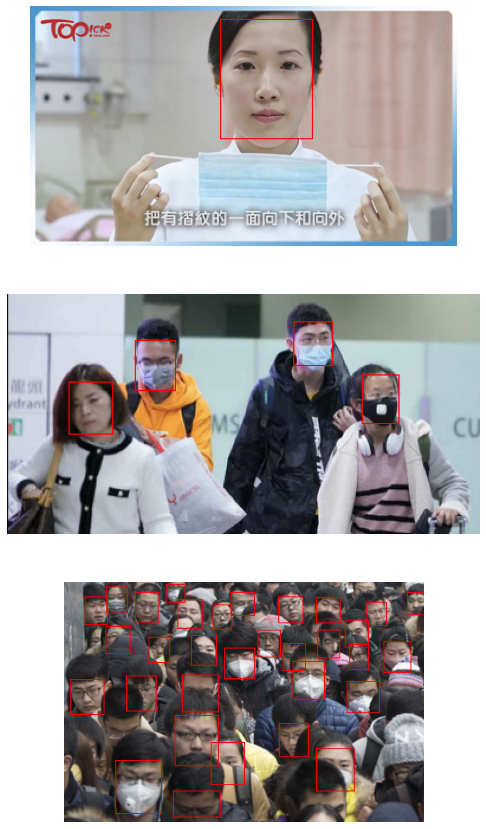

In [26]:
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = centerface_annotate(exemplary_imgs_files[i])
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector 10 - Tina Face

In [81]:
%%bash
cd vedadet
CUDA_VISIBLE_DEVICES="0" python tools/infer.py configs/infer/tinaface/tinaface.py ../dataset/trial/ground_truths.txt

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [82]:
import json
with open("vedadet/tina_results.json") as file:
    tina_results = json.load(file)

In [83]:
tina_filenames = []
for i in range(len(tina_results)):
    photo = tina_results[str(i)]
    tina_filenames.append(photo['filename'].replace("/am/dataset/second_approach/images/", ""))

In [84]:
def tina_annotate(filename, i=None):
    img = cv.imread(filename)
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = tina_filenames.index(file_name)
    file_results = tina_results[str(idx)]
    for i in range(len(file_results["objects"])):
        xmin = int(float((file_results["objects"][str(i)]["coordinates"]["x_min"])))
        xmax = int(float((file_results["objects"][str(i)]["coordinates"]["x_max"])))
        ymin = int(float((file_results["objects"][str(i)]["coordinates"]["y_min"])))
        ymax = int(float((file_results["objects"][str(i)]["coordinates"]["y_max"])))
        cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [85]:
def normalize_tina_results(filename, i=None):
    img = cv.imread(filename)
    faces  = []
    file_name = filename.replace("dataset/second_approach/images/", "")
    idx = tina_filenames.index(file_name)
    file_results = tina_results[str(idx)]
    for i in range(len(file_results["objects"])):
        xmin = int(float((file_results["objects"][str(i)]["coordinates"]["x_min"])))
        xmax = int(float((file_results["objects"][str(i)]["coordinates"]["x_max"])))
        ymin = int(float((file_results["objects"][str(i)]["coordinates"]["y_min"])))
        ymax = int(float((file_results["objects"][str(i)]["coordinates"]["y_max"])))
        faces.append((xmin, ymin, xmax, ymax))
    return faces

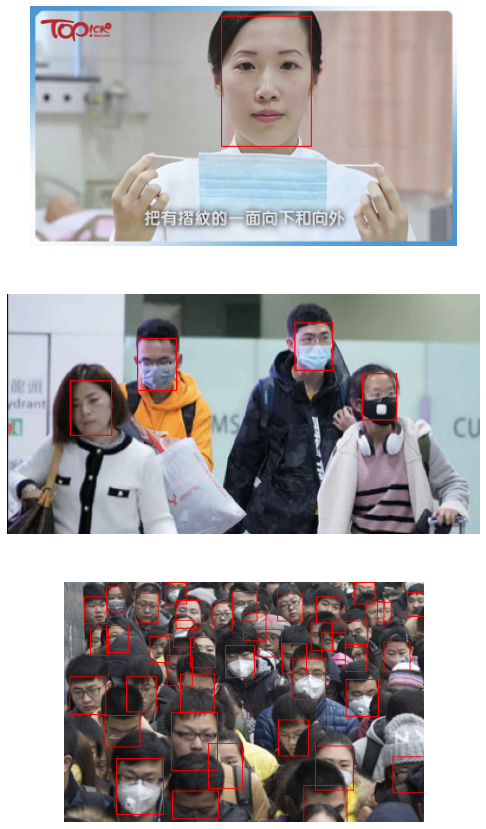

In [86]:
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = tina_annotate(exemplary_imgs_files[i])
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector 11 - Facenet pytorch

In [28]:
from facenet_pytorch import MTCNN
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [71]:
def facenet_annotate(filename, model):
    img = cv.imread(filename)
    boxes, probs = model.detect(img)
    i = 0
    if boxes is not None:
        for box in boxes:
            if probs[i] > 0.5:
                cv.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 1)
            i += 1
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [72]:
def normalize_facenet_results(filename, model):
    img = cv.imread(filename)
    faces = []
    boxes, probs = model.detect(img)
    i = 0
    if boxes is not None:
        for box in boxes:
            if probs[i] > 0.5:
                faces.append([int(coord) for coord in box])
            i += 1
    return faces

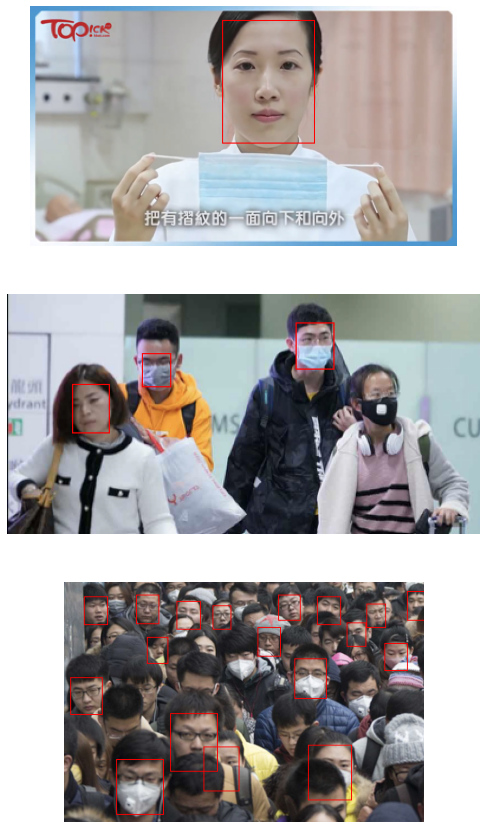

In [73]:
fig=plt.figure(figsize=(30, 15))
axes = []

for i in range(len(exemplary_imgs_files)):
    img = facenet_annotate(exemplary_imgs_files[i], facenet_detector)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

## Detector comparison

In [27]:
def iou_pass(bb_target, bb_pred):
    x_min = max(bb_target[0], bb_pred[0]) 
    y_min = max(bb_target[1], bb_pred[1])
    x_max = min(bb_target[2], bb_pred[2]) 
    y_max = min(bb_target[3], bb_pred[3]) 
    inter = max(0, x_max-x_min+1)*max(0, y_max-y_min+1)
    union = (bb_pred[2]-bb_pred[0]+1)*(bb_pred[3]-bb_pred[1]+1) + (bb_target[2]-bb_target[0]+1)*(bb_target[3]-bb_target[1]+1) - inter
    if inter/union > 0.5:
        return True
    return False

In [28]:
def size_class(area):
    if area < 16:
        return -1
    if area < 32**2:
        return 0
    if area < 96**2:
        return 1
    return 2

In [29]:
def estimate_model_prediction(bdbox, width, height, faces, unused, not_in_iou):
    is_left = True
    xmin = int((int(bdbox.find('xmin').text))/width)
    ymin = int((int(bdbox.find('ymin').text))/height)
    xmax = int((int(bdbox.find('xmax').text))/width)
    ymax = int((int(bdbox.find('ymax').text))/height)
    size_group = size_class((ymax-ymin)*(xmax-xmin))
    TP = 0
    FN = 0
    FP = 0
    if size_group != -1:
        for j in range(len(faces)):
            if iou_pass((xmin, ymin, xmax, ymax), (faces[j][0], faces[j][1], faces[j][2], faces[j][3])):
                if (not is_left or not unused[j]):
                    FP += 1
                else:
                    TP += 1
                    is_left = False
                    unused[j] = False
                not_in_iou[j] = False
        if (is_left):
            FN = 1
    return size_group, TP, FN, FP

In [30]:
def get_detections(model, norm_res, annots):
    FP = np.zeros(( 3, len(annots)))
    TP = np.zeros((3, len(annots)))
    FN = np.zeros((3, len(annots)))
    k = 0
    for img_annot in annots:
        tree = ET.parse(img_annot)
        root = tree.getroot()
    
        file = root.find('filename').text
        file_path = img_dir + file
        img = cv.imread(file_path)
        objects = root.findall('object')
        size = root.find('size')
        width = img.shape[1]/int(size.find('width').text)
        height = img.shape[0]/int(size.find('height').text)
        faces = norm_res(file_path, model)
        unused = [True]*len(faces)
        not_in_iou = [True]*len(faces)
        for i in range(len(objects)):
            bndbox = objects[i].find('bndbox')
            size_group, tp, fn, fp = estimate_model_prediction(bndbox, width, height, faces, unused, not_in_iou)
            TP[size_group, k] += tp
            FN[size_group, k] += fn
            FP[size_group, k] += fp
        FP[size_group, k] += sum(not_in_iou)
        k += 1 
    return FP, TP, FN

In [31]:
def save_detection_results(FP, TP, FN, model_name, filename='results.csv', header=False, mode='a'):
    overdetected = []
    for i in range(len(size)):
        overdetected.append(np.sum(FP[i, :]))
    d = pd.DataFrame(np.reshape(overdetected, (1, len(size))))
    d.index = [model_name]
    d.columns = ["over_"+cat for cat in size]

    for i in range(len(size)):
        det = []
        under = []
        det.append(np.sum(TP[i, :]))
        under.append(np.sum(FN[i, :]))
        d["det_"+size[i]] = det
        d["under_"+size[i]] = under
        d["total_faces_"+size[i]] = d["under_"+size[i]] +  d["det_"+size[i]]
        d["total_"+size[i]] = d["total_faces_"+size[i]] + d["over_"+size[i]]
    d = d[sorted(d.columns.values ,key = lambda x:x[-1])]
    d.reset_index(drop=False, inplace=True)
    d.to_csv(filename, header=header, mode=mode)

In [32]:
size = ["S", "M", "L"]

In [33]:
names = ["Haar", "DNN", "MTCNN", "HOG", "MMOD", 
         "3DDFA", "CrowdHuman", "RetinaFace",
        "CenterFace", "TinaFace", "Facenet"]

In [34]:
def save_precision_and_recall(FP, TP, FN, model_name, filename='results.csv', header=False, mode='a'):
    FP_img = np.sum(FP, axis=0)
    TP_img = np.sum(TP, axis=0)
    FN_img = np.sum(FN, axis=0)
    Precision = np.divide(TP_img, (FP_img+TP_img), out=np.zeros(TP_img.shape, dtype=float), where=(FP_img+TP_img)!=0)
    Recall = TP_img / (TP_img+FN_img)
    d= pd.DataFrame(data=[Precision, Recall], index=[model_name+"_P", model_name+"_R"])
    d.to_csv(filename, header=header, mode=mode)

### Haar results

In [122]:
FP, TP, FN = get_detections(haar_detector, normalize_haar_results, annot)

In [123]:
save_detection_results(FP, TP, FN, names[0], filename='results.csv', header=True, mode='w')
save_precision_and_recall(FP, TP, FN, names[0], filename='PR.csv', header=True, mode='w')

In [124]:
del FP, TP, FN, haar_detector

### DNN results

In [127]:
FP, TP, FN = get_detections(dnn_detector, normalize_dnn_results, annot)

In [128]:
save_detection_results(FP, TP, FN, names[1], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[1], filename='PR.csv')

In [129]:
del FP, TP, FN, dnn_detector

### MTCNN results

In [134]:
FP, TP, FN = get_detections(mtcnn_detector, normalize_mtcnn_results, annot)
save_detection_results(FP, TP, FN, names[2], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[2], filename='PR.csv')
del FP, TP, FN, mtcnn_detector

### HOG results

In [25]:
FP, TP, FN = get_detections(hog_detector, normalize_hog_results, annot)
save_detection_results(FP, TP, FN, names[3], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[3], filename='PR.csv')
del FP, TP, FN, hog_detector

### MMOD results

In [43]:
FP, TP, FN = get_detections(mmod_detector, normalize_mmod_results, annot)
save_detection_results(FP, TP, FN, names[4], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[4], filename='PR.csv')
del FP, TP, FN, mmod_detector

### 3DDFA results

In [51]:
FP, TP, FN = get_detections(face_boxes, normalize_3ddfa_results, annot)
save_detection_results(FP, TP, FN, names[5], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[5], filename='PR.csv')
del FP, TP, FN, face_boxes

### CrowdHuman results

In [65]:
FP, TP, FN = get_detections(None, normalize_crowdhuman_results, annot)
save_detection_results(FP, TP, FN, names[6], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[6], filename='PR.csv')
del FP, TP, FN

### Retina Results

In [70]:
FP, TP, FN = get_detections(retina_detector, normalize_retina_results, annot)
save_detection_results(FP, TP, FN, names[7], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[7], filename='PR.csv')
del FP, TP, FN, retina_detector

### CenterFace Results

In [40]:
FP, TP, FN = get_detections(None, normalize_centerface_results, annot)
save_detection_results(FP, TP, FN, names[8], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[8], filename='PR.csv')
del FP, TP, FN

### Tina results

In [87]:
FP, TP, FN = get_detections(None, normalize_tina_results, annot)
save_detection_results(FP, TP, FN, names[9], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[9], filename='PR.csv')
del FP, TP, FN

### Facenet pytorch results

In [76]:
FP, TP, FN = get_detections(facenet_detector, normalize_facenet_results, annot)
save_detection_results(FP, TP, FN, names[10], filename='results.csv')
save_precision_and_recall(FP, TP, FN, names[10], filename='PR.csv')
del FP, TP, FN, facenet_detector

### Comparison on face sizes

In [41]:
import matplotlib.patches as mpatches

In [42]:
sizes_names = ["Small", "Medium", "Large"]
size = ["S", "M", "L"]

In [88]:
res = pd.read_csv("results.csv")

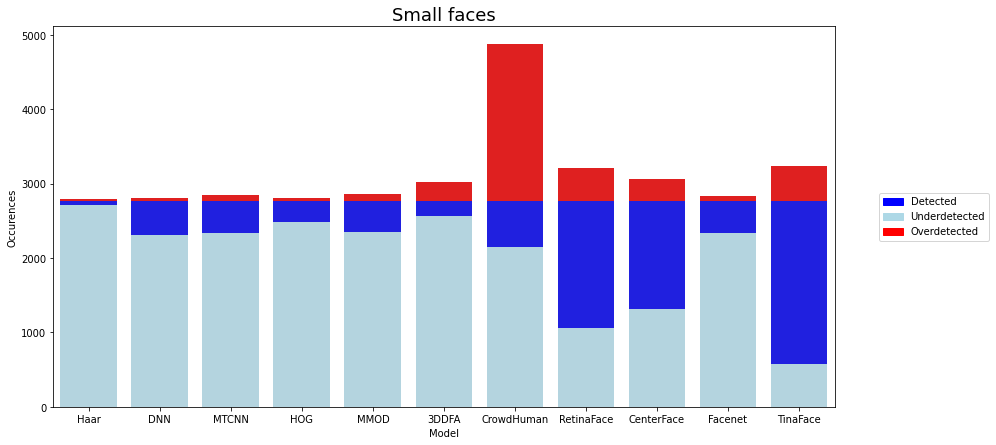

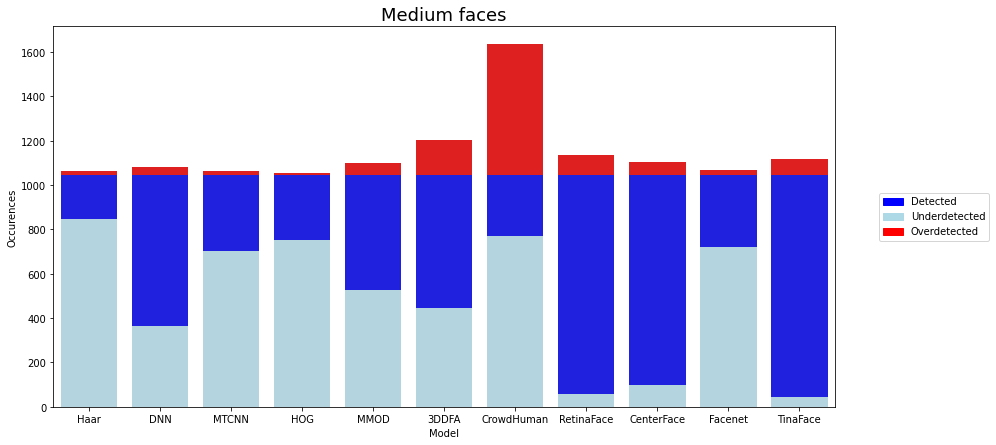

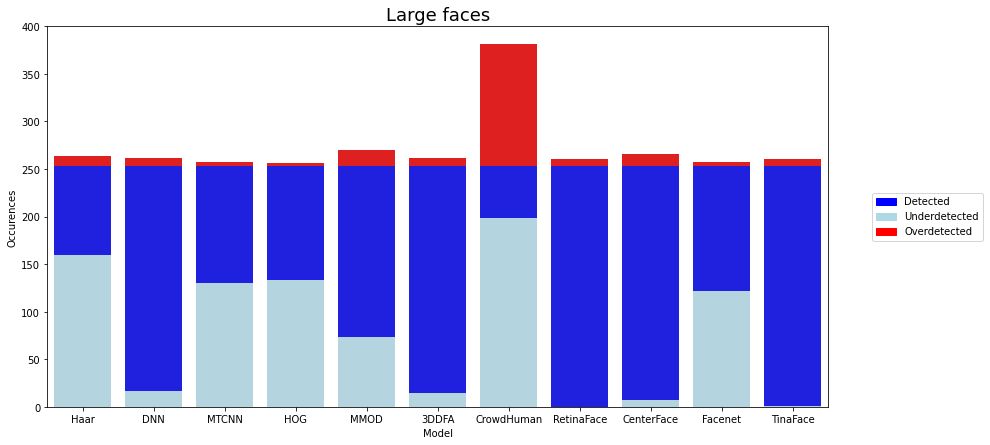

In [90]:
for i in range(len(sizes_names)):
    plt.figure(figsize=(14, 7))
    bar1 = sns.barplot(x="index",  y="total_"+size[i], data=res, color='red')
    bar2 = sns.barplot(x="index", y="total_faces_"+size[i], data=res,  color='blue')
    bar3 = sns.barplot(x="index", y="under_"+size[i], data=res,  color='lightblue')
    plt.title(sizes_names[i] +" faces", size=18)
    plt.xlabel("Model")
    plt.ylabel("Occurences")
    top_bar = mpatches.Patch(color='blue', label='Detected')
    bottom_bar = mpatches.Patch(color='lightblue', label='Underdetected')
    medium_bar = mpatches.Patch(color='red', label='Overdetected')
    plt.legend(handles=[top_bar, bottom_bar, medium_bar], bbox_to_anchor=(1.05, 0.5), 
           loc='center left')
    plt.show()

### Best and worst photos

In [192]:
wb_imgs_paths = [worst_img_path, best_img_path]

In [193]:
wb_annot = [path.replace("images", "annotations") for path in wb_imgs_paths]
wb_annot = [path.replace(".png", ".xml") for path in wb_annot]

In [248]:
wb_imgs = [cv.imread(file) for file in wb_imgs_paths]
wb_images, wb_labels, wb_files = extract_faces(wb_annot, return_bdbox=True)
for i in range(len(wb_images)):
    bdbox = wb_images[i]
    idx = wb_imgs_paths.index(wb_files[i])
    cv.rectangle(wb_imgs[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 1)

In [ ]:
for i in range(len(wb_imgs)):
    fig=plt.figure(figsize=(20, 20))
    axes = []
    img = cv.cvtColor(wb_imgs[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 1, i+1))
    plt.axis('off')
    plt.imshow(img)

In [309]:
foos = [(haar_annotate, haar_detector), (dnn_annotate, dnn_detector), (mtcnn_annotate, mtcnn_detector), (dlib_annotate, dlib_detector), (ddfa_annotate, face_boxes), (crowd_human_annotate, None)]
annot = ["Haar", "DNN", "MTCNN","Dlib", "3DDFA", "CrowdHuman"]

In [ ]:
for i in range(len(wb_imgs_paths)):
    fig=plt.figure(figsize=(35, 15))
    axes = []
    for j in range(len(foos)):
        image = foos[j][0](wb_imgs_paths[i], foos[j][1])
        axes.append(fig.add_subplot(2, 3, j+1))
        plt.text(0, 0, annot[j], fontsize=30)
        plt.axis('off')
        plt.imshow(image)